In [1]:
import numpy as np
from numpy.linalg import inv
from math import log
import matplotlib.pyplot as plt

# 9.30 Gradient and Newton methods

$$
\min f(x) = - \sum_{k=1}^m log(1-a_k^Tx) - \sum_{i=1}^n log(1-x_i^2)
$$


a) Use the gradient method to solve the problem, using reasonable choices for the back-
tracking parameters, and a stopping criterion of the form k∇f (x)k 2 ≤ η. Plot the
objective function and step length versus iteration number. (Once you have deter-
mined p ⋆ to high accuracy, you can also plot f − p ⋆ versus iteration.) Experiment
with the backtracking parameters α and β to see their effect on the total number of
iterations required. Carry these experiments out for several instances of the problem,
of different sizes.

(b) Repeat using Newton’s method, with stopping criterion based on the Newton decre-
ment λ 2 . Look for quadratic convergence. You do not have to use an efficient method
to compute the Newton step, as in exercise 9.27; you can use a general purpose dense
solver, although it is better to use one that is based on a Cholesky factorization.


$$\nabla f(x)= \sum_{k=1}^m \frac{a_{ki}}{1+a_k^Tx} + \frac{1}{1-x_i} - \frac{1}{1+x_i}$$

$$\nabla^2 f(x)=
\begin{bmatrix}
\sum_{k=1}^m \frac{a_{ki}^2}{(1+a_k^Tx)^2} + \frac{1}{(1+x_i)^2}  + \frac{1}{(1-x_i)^2} & \sum_{k=1}^m \frac{a_{ki}^2}{(1+a_k^Tx)^2}  \\
\sum_{k=1}^m \frac{a_{ki}^2}{(1+a_k^Tx)^2}   & \dots
\end{bmatrix}
$$

/tmp/ipykernel_7830/1360147138.py:71: RuntimeWarning: invalid value encountered in log
  return -sum(np.log(1-A@x)) - sum(np.log(1-x**2))


Grad x* - Newton x*:0.00025


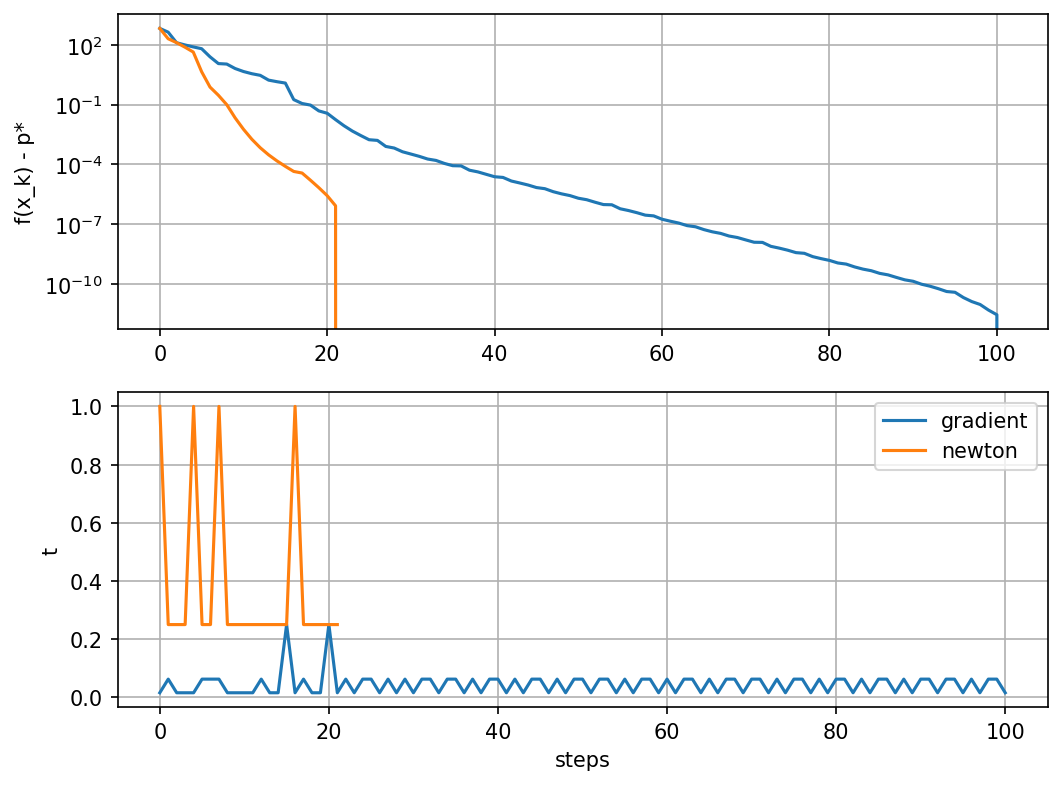

In [2]:
MAXIT=500


def gradient_descent(f, df, alpha, beta, x0):
    eta=1e-5 # Stopping criterion
    x_k = [x0]
    t_k = []
    x = x0
    for i in range(MAXIT):

        # 1. Determine a descent direction ∆x
        deltax = -df(x)
        # 2. Line search: choose a step size t > 0
        t = 1.0
        #2.1 Guarantee x in dom f(x)
        while np.isnan(f(x+t*deltax)):
            t = beta*t
        #2.2 Backtrack
        while f(x + t*deltax) > f(x) + alpha*t*df(x)@deltax:
                t = beta*t
        # 3. Update: x := x + t∆x
        x = x + t*deltax
        x_k.append(x)
        t_k.append(t)
        if np.linalg.norm(df(x)) < eta:
            break
        
    return x_k, t_k, f(x)
    
    
def newton_method(f, df, ddf, alpha, beta, x0):
    epsilon = 1e-5
    x_k = [x0]
    t_k = []
    x = x0
    lambd = 1e10
    for i in range(MAXIT):
        # 1. Determine a descent direction ∆x
        deltax = -inv(ddf(x))@df(x)
        lambd = -df(x)@deltax
        # 2. Line search: choose a step size t > 0
        t = 1.0
        #2.1 Guarantee x in dom f(x)
        while np.isnan(f(x+t*deltax)):
            t = beta*t
        
        #2.2 Backtrack
        while f(x + t*deltax) > f(x) + alpha*t*df(x)@deltax:
                t = beta*t
                
        # 3. Update: x := x + t∆x
        x = x + t*deltax
        x_k.append(x)
        t_k.append(t)
        if lambd/2 < epsilon:
            break
    
    return x_k, t_k, f(x)


m = 1000
n = 500

n=1000
m=1000
A=np.random.uniform(-1/4,1/4,(m,n))
x0=np.zeros(n)


def f(x):
    return -sum(np.log(1-A@x)) - sum(np.log(1-x**2))

def df(x):
    return A.T@(1/(1-A@x)) + 2*x/(1-x**2)

def ddf(x):
    return (1/(1-A@x)**2) * A.T@A + 2*np.diag((1+x)/(1-x**2)**2)


x0 = np.abs(np.random.rand(n))/100
x0 = np.zeros(n)
alpha = 0.01
beta = 0.25

x_k, t_k, f_star = gradient_descent(f, df, alpha, beta, x0)
fk = [f(x) for x in x_k]
fig, ax = plt.subplots(2, 1, figsize=(8, 6), dpi=150)
ax[0].semilogy(fk-f_star, label="gradient")
ax[1].plot(t_k, label="gradient")
x_star1 = x_k[-1]

x_k, t_k, f_star = newton_method(f, df, ddf, alpha, beta, x0)
fk = [f(x) for x in x_k]
ax[0].semilogy(fk-f_star, label="newton")
ax[1].plot(t_k, label="newton")
x_star2 = x_k[-1]

ax[0].set_ylabel("f(x_k) - p*")
ax[1].set_ylabel("t")
ax[1].set_xlabel("steps")
plt.legend()
ax[0].grid()
ax[1].grid()

print(f"Grad x* - Newton x*:{np.linalg.norm(x_star1-x_star2):.3}")



# 10.15 Equality constrained entropy maximization.

$$
\min ~f(x) = \sum_{i=1}^{n} x_i log(x_i)
$$
$$
subject~to~Ax=b
$$

(a) Standard Newton method. You can use initial point x (0) = x̂.

(b) Infeasible start Newton method. You can use initial point x (0) = x̂ (to compare with
the standard Newton method), and also the initial point x (0) = 1.

(c) Dual Newton method, i.e., the standard Newton method applied to the dual problem.




$\nabla f(x) = 1+ log(x_i)$

$\nabla^2 f(x) = 1/x_i$

In [3]:
#https://www.cs.cmu.edu/~ggordon/10725-F12/scribes/10725_Lecture12.pdf

def eqc_newton(f, df, ddf, A, alpha, beta, x0):
    lambd = 1e10
    epsilon = 1e-7
    x = x0
    x_k = [x0]
    t_k = []
    for i in range(100):
        #1. Compute the Newton step and decrement ∆x nt , λ(x).
        upper = np.concatenate([ddf(x), A.T], axis=1)
        lower = np.concatenate([A, np.zeros((A.shape[0], A.shape[0]))], axis=1)
        matrix = np.concatenate([upper, lower], axis =0)
        vector = np.append(-df(x), np.zeros(A.shape[0]))
        result = inv(matrix)@vector
        
        delta_x = result[0:len(x)]

        lambd = np.sqrt(delta_x.T@ddf(x)@delta_x)
        
        #2. Stopping criterion. quit if λ 2 /2 ≤ ǫ.
        if lambd/2 < epsilon:
            break
        
        #3. Line search. Choose step size t by backtracking line search.
        t = 1.0
        
#         #3.1 Guarantee x in dom f(x)
#         while min(x+t*delta_x) <= 0:
#             t = beta*t
        
        
        #3.1 Line search x in dom f(x)
        while f(x + t*delta_x) > f(x) + alpha*t*df(x).T@delta_x:
                t = beta*t
        
        #4. Update. x := x + t∆x nt .
        x = x + t*delta_x
        x_k.append(x)
        t_k.append(t)
        
        
    return x_k, t_k, f(x)
        
def eqc_infeasible_newton(f, df, ddf, A, b, alpha, beta, x0, v0):
    lambd = 1e10
    epsilon = 1e-7
    x = x0.copy()
    v = v0
    x_k = [x0]
    t_k = []
    for i in range(100):
        #1. Compute the Newton step and decrement ∆x nt , λ(x).
        upper = np.concatenate([ddf(x), A.T], axis=1)
        lower = np.concatenate([A, np.zeros((A.shape[0], A.shape[0]))], axis=1)
        matrix = np.concatenate([upper, lower], axis =0)
        vector = -np.append(df(x), A@x-b)
        
        result = inv(matrix)@vector
        
        delta_x = result[0:len(x)]
        w = result[len(x):]
        delta_v = w - v
        
        def r(x, v):
            primal = df(x) + A.T@v,
            dual = A@x-b
            return np.append(primal, dual)
        
        
        #2. Stopping criterion
        if sum(A@x - b) <= epsilon and np.linalg.norm(r(x, v)) <= epsilon:
            break
        
        #3. Line search. Choose step size t by backtracking line search.
        t = 1.0
        #3.1 Guarantee x in dom f(x)
        while min(x+t*delta_x) <= 0:
            t = beta*t
        
        
        
        while np.linalg.norm(r(x+t*delta_x, v+t*delta_v)) > (1-alpha*t)*np.linalg.norm(r(x, v)):
            t = beta*t
        
        #4. Update. x := x + t∆x nt .
        x = x + t*delta_x
        v = v+ t*delta_v
        x_k.append(x)
        t_k.append(t)
        
    return x_k, t_k, f(x)


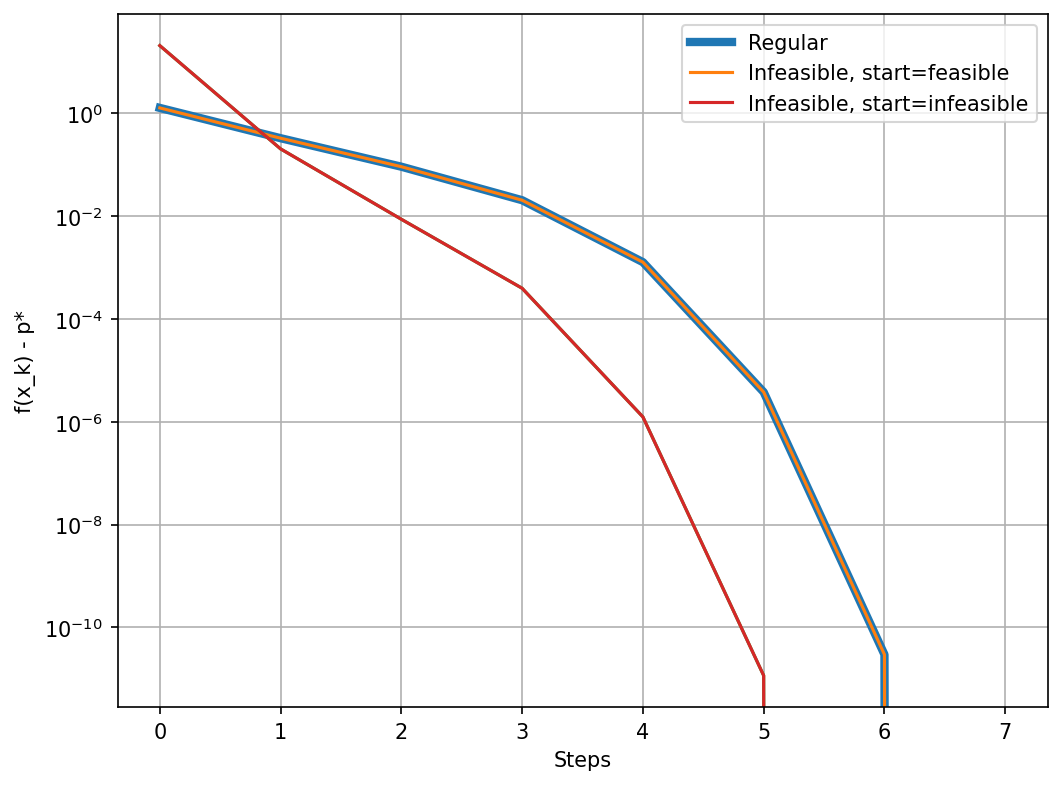

In [4]:
def f(x):
    return sum([xi*log(xi) for xi in x])

def df(x):
    return np.array([1+log(xi) for xi in x])

def ddf(x):
    A = np.identity(len(x))
    for i in range(len(x)):
        A[i,i] = 1/x[i]
    return A
        
#n = 100 and p = 30 by choosing A randomly (checking that it has full rank)
n = 100
p = 30
A = np.random.rand(p, n)
x0 = np.abs(np.random.rand(n))
x0 = x0/np.linalg.norm(x0)
b = A@x0
assert np.linalg.matrix_rank(A) == p
alpha = 0.2
beta = 0.5



x_k, t_k, f_star = eqc_newton(f, df, ddf, A, alpha, beta, x0) 
fk = [f(x) for x in x_k]

fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=150)
ax.semilogy(fk-f_star, label="Regular", linewidth=4)
ax.set_ylabel("f(x_k) - p*")
ax.set_xlabel("Steps")
ax.grid()
x_star1 = x_k[-1]



v0 = np.zeros(p)


x_k, t_k, f_star = eqc_infeasible_newton(f, df, ddf, A, b, alpha, beta, x0, v0) 
fk = [f(x) for x in x_k]
ax.semilogy(fk-f_star, label="Infeasible, start=feasible")
x_star2 = x_k[-1]


x0 = np.ones(n)
x_k, t_k, f_star = eqc_infeasible_newton(f, df, ddf, A, b, alpha, beta, x0, v0) 
fk = [f(x) for x in x_k]
plt.semilogy(np.abs(fk-f_star))
ax.semilogy(fk-f_star, label="Infeasible, start=infeasible")

ax.legend()

Newton x* - Infeasible newton x*:3.19e-15
Newton x* - Dual newton x*:7.76e-07


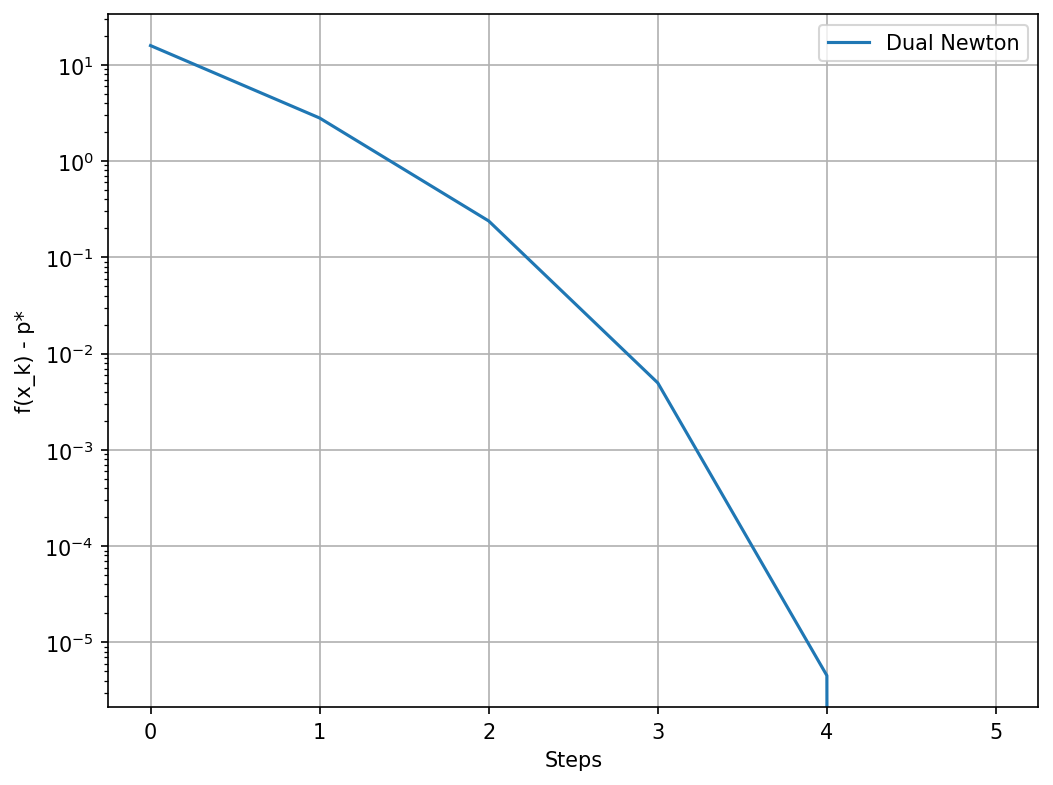

In [6]:
def f(nu):
    return b@nu + sum(np.exp(-A.T@nu-1))
    
def df(nu):
    return b - A@np.exp(-A.T@nu-1)
    
def ddf(nu):
    return A@np.diag(np.exp(-A.T@nu-1))@A.T


v_k, t_k, f_star = newton_method(f, df, ddf, alpha, beta, v0)
fk = [f(x) for x in v_k]
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=150)
ax.semilogy(fk-f_star, label="Dual Newton")
ax.set_ylabel("f(x_k) - p*")
ax.set_xlabel("Steps")
ax.grid()
ax.legend()
x_star3 = np.exp(-(1+A.T@v_k[-1]))

print(f"Newton x* - Infeasible newton x*:{np.linalg.norm(x_star1-x_star2):.3}")
print(f"Newton x* - Dual newton x*:{np.linalg.norm(x_star1-x_star3):.3}")